In [901]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import Lasso, LassoCV, Ridge

#### Key objectives:
- Handle missing values
- Determine what each categorical value represents and rename values and/or columns(reference read data dictionary)
- Identify outliers.
- Handle inconsistent categorical value frequency between train and test data.
- Consider whether discrete values are better represented as categorical or continuous. (Are relationships to the target linear?) i.e. 

In [902]:
train = pd.read_csv('../data/train.csv')

In [903]:
test = pd.read_csv('../data/test.csv')

In [904]:
# makes Jupyter show all rows and columns for better visibility
pd.options.display.max_rows = train.shape[1]
pd.options.display.max_columns = train.shape[1]
pd.set_option('display.max_columns', 300)

In [905]:
train.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000


In [906]:
train.shape

(2051, 81)

In [907]:
train.dtypes

Id                   int64
PID                  int64
MS SubClass          int64
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Alley               object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1       float64
BsmtFin Type 2      object
B

In [908]:
# Baseline model is the mean house price
baseline = '{:,.2f}'.format(round(train['SalePrice'].mean()))
print(f'${baseline}')

$181,470.00


## Data Cleaning

I started by renaming the columns for readability via the data dictionary

In [909]:
renamed_columns = {
    'Pool QC': 'pool_quality',
    'Fence': 'fence_quality',
    'Mas Vnr Type': 'masonry_veneer_type',
    'Fireplace Qu': 'fireplace_quality',
    'Lot Frontage': 'lot_frontage',
    'Garage Qual': 'garage_quality',
    'Garage Finish': 'garage_finish(renovated)',
    'Garage Yr Blt': 'garage_yr_built',
    'Garage Cond': 'garage_condition',
    'Garage Type': 'garage_type',
    'Bsmt Exposure': 'bsmt_exposure',
    'BsmtFin Type 2': '2nd_finish_bsmt_qual',
    'Bsmt Cond': 'bsmt_cond',
    'Bsmt Qual': 'bsmt_qual',
    'BsmtFin Type 1': 'finish_bsmt_qual',
    'Mas Vnr Area': 'masonry_veneer_area',
    'Bsmt Half Bath': 'bsmt_half_bath',
    'Bsmt Full Bath': 'bsmt_full_bath',
    'Garage Area': 'garage_area',
    'Total Bsmt SF': 'bsmt_SF',
    'Bsmt Unf SF': 'bsmt_unf_SF',
    'BsmtFin SF 2': 'bsmt_2_finish_SF',
    'BsmtFin SF 1': 'bsmt_finish_SF',
    'Garage Cars': 'garage_cars',
    'Mo Sold': 'month_sold',
    'Yr Sold': 'year_sold',
    'Sale Type': 'sale_type',
    'Functional': 'home_functionality',
    '3Ssn Porch': '3_ssn_porch_area',
    'Gr Liv Area': 'gr_liv_area',
    'Heating QC': 'heating_qual',
    'MS SubClass': 'building_class',
    'MS Zoning': 'zoning_classification_of_sale',
    'Condition 1': 'prox_to_mainroad_or_railroad',
    'Condition 2': 'prox_to_mainroad_or_railroad_2nd',
    'Year Remod/Add': 'remodel_date',
    'Exterior 1st': 'exterior_type',
    'Exterior 2nd': 'exterior_type_2nd',
    'Foundation': 'foundation_type',
    'Central Air': 'central_air',
    'Electrical': 'electrical_type',
    'Alley': 'alley_access'
}

# Rename column headers
train.rename(columns=renamed_columns, inplace=True)


In [910]:
# Created sale date column for timeseries analysis
# train['sale_date'] = train['year_sold'].astype(str) + '-' + train['month_sold'].astype(str)

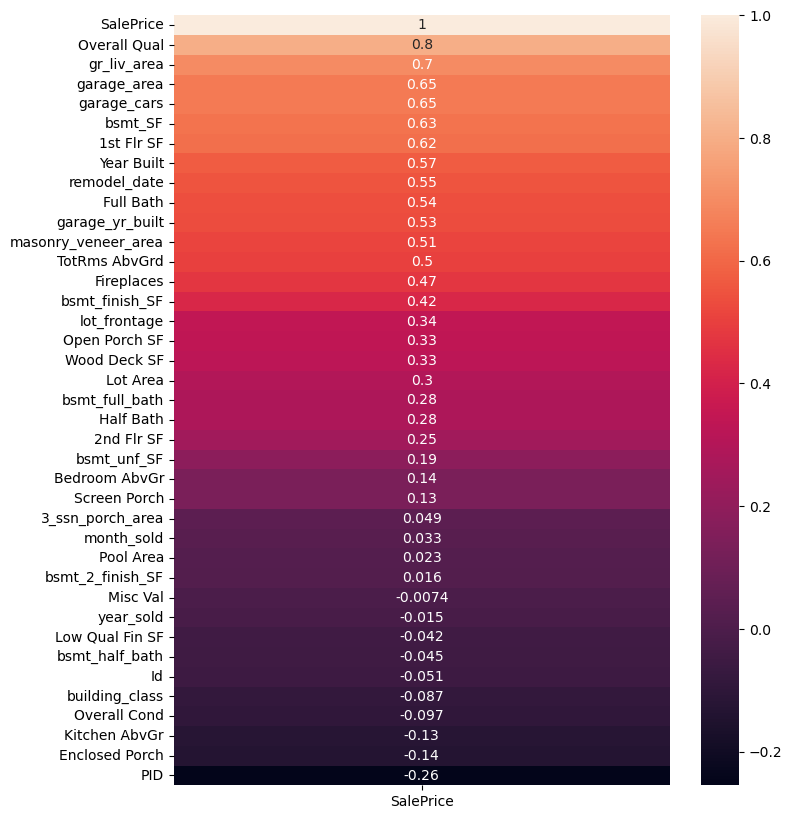

In [911]:
# shows the highest corellating variables // Started with top 12 variables in my first model.
plt.figure(figsize=(8,10))
sns.heatmap(train.corr(numeric_only=True)[['SalePrice']].sort_values(by='SalePrice', ascending = False), annot=True);

### Missing values

In [912]:
# All missing values from highest to lowest
train.isnull().sum().sort_values(ascending=False).head(28)

pool_quality                2042
Misc Feature                1986
alley_access                1911
fence_quality               1651
masonry_veneer_type         1240
fireplace_quality           1000
lot_frontage                 330
garage_quality               114
garage_finish(renovated)     114
garage_yr_built              114
garage_condition             114
garage_type                  113
bsmt_exposure                 58
2nd_finish_bsmt_qual          56
bsmt_cond                     55
bsmt_qual                     55
finish_bsmt_qual              55
masonry_veneer_area           22
bsmt_half_bath                 2
bsmt_full_bath                 2
garage_area                    1
bsmt_SF                        1
bsmt_unf_SF                    1
bsmt_2_finish_SF               1
bsmt_finish_SF                 1
garage_cars                    1
month_sold                     0
sale_type                      0
dtype: int64

#### Below it's observed that each category where there's a null value represents that the feature does not exist for that property. We will then replace the nulls with "none" or 0 to represent that.

In [913]:
# Show all categorical columns and their values
cat_columns = train.select_dtypes(include='object').columns.tolist()
for col in cat_columns:
    print(f'{col}: ({train[col].nunique()}) -> {train[col].unique()}')

zoning_classification_of_sale: (7) -> ['RL' 'RM' 'FV' 'C (all)' 'A (agr)' 'RH' 'I (all)']
Street: (2) -> ['Pave' 'Grvl']
alley_access: (2) -> [nan 'Pave' 'Grvl']
Lot Shape: (4) -> ['IR1' 'Reg' 'IR2' 'IR3']
Land Contour: (4) -> ['Lvl' 'HLS' 'Bnk' 'Low']
Utilities: (3) -> ['AllPub' 'NoSeWa' 'NoSewr']
Lot Config: (5) -> ['CulDSac' 'Inside' 'Corner' 'FR2' 'FR3']
Land Slope: (3) -> ['Gtl' 'Sev' 'Mod']
Neighborhood: (28) -> ['Sawyer' 'SawyerW' 'NAmes' 'Timber' 'Edwards' 'OldTown' 'BrDale'
 'CollgCr' 'Somerst' 'Mitchel' 'StoneBr' 'NridgHt' 'Gilbert' 'Crawfor'
 'IDOTRR' 'NWAmes' 'Veenker' 'MeadowV' 'SWISU' 'NoRidge' 'ClearCr'
 'Blmngtn' 'BrkSide' 'NPkVill' 'Blueste' 'GrnHill' 'Greens' 'Landmrk']
prox_to_mainroad_or_railroad: (9) -> ['RRAe' 'Norm' 'PosA' 'Artery' 'Feedr' 'PosN' 'RRAn' 'RRNe' 'RRNn']
prox_to_mainroad_or_railroad_2nd: (8) -> ['Norm' 'RRNn' 'Feedr' 'Artery' 'PosA' 'PosN' 'RRAe' 'RRAn']
Bldg Type: (5) -> ['1Fam' 'TwnhsE' 'Twnhs' '2fmCon' 'Duplex']
House Style: (8) -> ['2Story' '1St

In [914]:
# show all the categories for columns with more than 5 nulls
null_counts = train.isnull().sum()
null_columns = null_counts[null_counts > 5].index.tolist()

for column in train[null_columns]:
    print(f'{column}: {train[column].unique()}')

lot_frontage: [ nan  43.  68.  73.  82. 137.  35.  70.  21.  64. 120.  24.  74.  93.
  34.  80.  71.  72. 109.  40. 103. 100.  92.  65.  75.  60.  30.  79.
  41. 105. 107.  81.  36.  63.  32.  94.  44.  50.  48.  67.  88.  83.
  53.  58.  57.  52.  87. 134.  56.  54. 140.  78.  85.  90.  96.  62.
  49.  59. 155.  91.  61.  86. 128.  77.  42.  89.  51.  69.  55. 112.
  76. 125.  98. 113. 102.  22. 122.  84. 119. 118.  66.  95. 108. 195.
 106.  39. 110. 130.  97.  45.  37. 123.  38. 129. 115.  47. 114. 104.
  46. 121. 124. 313. 141. 101.  99. 160. 174.  26. 144. 138. 111.  25.
  33. 200. 150. 117. 153. 116. 135.]
alley_access: [nan 'Pave' 'Grvl']
masonry_veneer_type: ['BrkFace' nan 'Stone' 'BrkCmn']
masonry_veneer_area: [2.890e+02 1.320e+02 0.000e+00 8.200e+01 1.800e+02 1.920e+02 2.320e+02
 4.560e+02 1.480e+02       nan 3.000e+00 3.360e+02 4.800e+02 3.200e+02
 1.040e+02 3.350e+02 4.000e+01 1.100e+02 1.060e+02 5.130e+02 1.840e+02
 5.220e+02 1.430e+02 3.480e+02 1.170e+02 5.100e+02 1.450e+0

In [915]:
# Drop rows in columns with 5 or less nulls
train.dropna(subset=['bsmt_full_bath', 
                     'bsmt_half_bath', 
                     'bsmt_finish_SF', 
                     'garage_cars', 
                     'bsmt_SF', 
                     'bsmt_unf_SF', 
                     'bsmt_2_finish_SF', 
                     'garage_area'], inplace=True)

In [916]:
# Replace nulls in categorical columns with 'None'
for col in train.select_dtypes(include=['object']):
    train[col].fillna('None', inplace=True)

In [917]:
# Confirm no nulls exist
train.isnull().sum().sort_values(ascending=False).head()

lot_frontage           330
garage_yr_built        113
masonry_veneer_area     22
Bedroom AbvGr            0
garage_type              0
dtype: int64

## Pre-Processing & Encoding

In [918]:
cat_columns = train.select_dtypes(include='object').columns.tolist()
cat_columns

['zoning_classification_of_sale',
 'Street',
 'alley_access',
 'Lot Shape',
 'Land Contour',
 'Utilities',
 'Lot Config',
 'Land Slope',
 'Neighborhood',
 'prox_to_mainroad_or_railroad',
 'prox_to_mainroad_or_railroad_2nd',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'exterior_type',
 'exterior_type_2nd',
 'masonry_veneer_type',
 'Exter Qual',
 'Exter Cond',
 'foundation_type',
 'bsmt_qual',
 'bsmt_cond',
 'bsmt_exposure',
 'finish_bsmt_qual',
 '2nd_finish_bsmt_qual',
 'Heating',
 'heating_qual',
 'central_air',
 'electrical_type',
 'Kitchen Qual',
 'home_functionality',
 'fireplace_quality',
 'garage_type',
 'garage_finish(renovated)',
 'garage_quality',
 'garage_condition',
 'Paved Drive',
 'pool_quality',
 'fence_quality',
 'Misc Feature',
 'sale_type']

In [919]:
encoded_features = pd.get_dummies(train[cat_columns], drop_first=False)

In [920]:
# Replace nulls in numerical columns with 0
num_features = train.select_dtypes(include=['number'])
for col in num_features:
    num_features[col].fillna(0, inplace=True)

In [921]:
num_features.isnull().sum().sort_values(ascending=False).head()

Id               0
Wood Deck SF     0
Bedroom AbvGr    0
Kitchen AbvGr    0
TotRms AbvGrd    0
dtype: int64

In [922]:
train['Heating'].unique()

array(['GasA', 'GasW', 'Grav', 'Wall', 'OthW'], dtype=object)

### Concat cleaned numeric and categorical dataframes

In [923]:
# make new dataframe with encoded features and numeric columns
train = pd.concat([encoded_features, num_features], axis=1)

In [924]:
# Confirm no nulls exist
train.isnull().sum().sort_values(ascending=False).head()

zoning_classification_of_sale_A (agr)    0
Kitchen Qual_TA                          0
home_functionality_Sev                   0
home_functionality_Sal                   0
home_functionality_Mod                   0
dtype: int64

## Removing outliers

##### Function that removes outliers in all columns with a threshold higher than a Z Score of 3
##### Cite source: ChatGPT for the Z Score formula.
def drop_outliers(df, columns):
    for column in columns:
        z_scores = (df[column] - df[column].mean()) / df[column].std()
        outliers = df[np.abs(z_scores) > 3]
        df = df.drop(outliers.index)
    return df

train = drop_outliers(train, train.columns)

## Modeling

In [925]:
xvars = train.drop('SalePrice', axis=1)
X = xvars
y = train['SalePrice']

In [926]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

In [927]:
# adding select categorical  features improved model from 84% to 91.9%

In [928]:
# Apply Standard Scalar
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [929]:
# Linear regression with standard scalar
model = LinearRegression()
model.fit(Z_train, y_train)
model.score(Z_train, y_train), model.score(Z_test, y_test)

(0.9459884790875712, -7.366710385454549e+23)

In [930]:
# removing scaling improved test score from -4.70% to 90.7%
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9460817905027916, 0.9075540973533627)

In [931]:
# I refit the model multiple times with diferent combinations of variables, some scaled, some not. I tried Lasso, Ridge. 
# I found the best score was with the all numeric and categorical variables used only after handling nulls for each column type without scaling.

## Test Pre-Processing

In [932]:
# Refit on all data (ONLY IF USING STANDARD SCALING)
# sc = StandardScaler()
# Z = sc.fit_transform(X)

model.fit(X, y)
print(model.score(X, y))

0.9437666274768811


In [933]:
missing_columns = train.columns.difference(test.columns)
print("Missing columns in test:", missing_columns)

Missing columns in test: Index(['2nd_finish_bsmt_qual_ALQ', '2nd_finish_bsmt_qual_BLQ',
       '2nd_finish_bsmt_qual_GLQ', '2nd_finish_bsmt_qual_LwQ',
       '2nd_finish_bsmt_qual_None', '2nd_finish_bsmt_qual_Rec',
       '2nd_finish_bsmt_qual_Unf', '3_ssn_porch_area', 'Bldg Type_1Fam',
       'Bldg Type_2fmCon',
       ...
       'sale_type_Oth', 'sale_type_WD ', 'year_sold',
       'zoning_classification_of_sale_A (agr)',
       'zoning_classification_of_sale_C (all)',
       'zoning_classification_of_sale_FV',
       'zoning_classification_of_sale_I (all)',
       'zoning_classification_of_sale_RH', 'zoning_classification_of_sale_RL',
       'zoning_classification_of_sale_RM'],
      dtype='object', length=285)


In [934]:
renamed_columns = {
    'Pool QC': 'pool_quality',
    'Fence': 'fence_quality',
    'Mas Vnr Type': 'masonry_veneer_type',
    'Fireplace Qu': 'fireplace_quality',
    'Lot Frontage': 'lot_frontage',
    'Garage Qual': 'garage_quality',
    'Garage Finish': 'garage_finish(renovated)',
    'Garage Yr Blt': 'garage_yr_built',
    'Garage Cond': 'garage_condition',
    'Garage Type': 'garage_type',
    'Bsmt Exposure': 'bsmt_exposure',
    'BsmtFin Type 2': '2nd_finish_bsmt_qual',
    'Bsmt Cond': 'bsmt_cond',
    'Bsmt Qual': 'bsmt_qual',
    'BsmtFin Type 1': 'finish_bsmt_qual',
    'Mas Vnr Area': 'masonry_veneer_area',
    'Bsmt Half Bath': 'bsmt_half_bath',
    'Bsmt Full Bath': 'bsmt_full_bath',
    'Garage Area': 'garage_area',
    'Total Bsmt SF': 'bsmt_SF',
    'Bsmt Unf SF': 'bsmt_unf_SF',
    'BsmtFin SF 2': 'bsmt_2_finish_SF',
    'BsmtFin SF 1': 'bsmt_finish_SF',
    'Garage Cars': 'garage_cars',
    'Mo Sold': 'month_sold',
    'Yr Sold': 'year_sold',
    'Sale Type': 'sale_type',
    'Functional': 'home_functionality',
    '3Ssn Porch': '3_ssn_porch_area',
    'Gr Liv Area': 'gr_liv_area',
    'Heating QC': 'heating_qual',
    'MS SubClass': 'building_class',
    'MS Zoning': 'zoning_classification_of_sale',
    'Condition 1': 'prox_to_mainroad_or_railroad',
    'Condition 2': 'prox_to_mainroad_or_railroad_2nd',
    'Year Remod/Add': 'remodel_date',
    'Exterior 1st': 'exterior_type',
    'Exterior 2nd': 'exterior_type_2nd',
    'Foundation': 'foundation_type',
    'Heating QC': 'heating_qual',
    'Central Air': 'central_air',
    'Electrical': 'electrical_type',
    'Alley': 'alley_access'
}

# Rename column headers
test.rename(columns=renamed_columns, inplace=True)


In [935]:
# Drop rows in columns with 5 or less nulls
test.dropna(subset=['bsmt_full_bath', 
                     'bsmt_half_bath', 
                     'bsmt_finish_SF', 
                     'garage_cars', 
                     'bsmt_SF', 
                     'bsmt_unf_SF', 
                     'bsmt_2_finish_SF', 
                     'garage_area'], inplace=True)

In [936]:
# Replace nulls in categorical columns with 'None'
for col in test.select_dtypes(include=['object']):
    if test[col].dtype == 'object':
        test[col].fillna('None', inplace=True)

In [937]:
cat_columns = test.select_dtypes(include='object').columns.tolist()
encoded_features = pd.get_dummies(test[cat_columns], drop_first=False)

In [938]:
test.shape

(878, 80)

In [939]:
# Replace nulls in numerica columns with 0
num_features = test.select_dtypes(include=['number'])
for col in num_features:
    num_features[col].fillna(0, inplace=True)

In [940]:
test = pd.concat([encoded_features, num_features], axis=1)

In [941]:
# Add all columns from train to test that were missed after dumbifying with "False" as all values
for col in train.columns:
    if col not in test.columns:
        test[col] = False

In [942]:
# Add all columns from test to train that were missed after dumbifying with "False" as all values
for col in test.columns:
    if col not in train.columns:
        train[col] = False

In [943]:
test = test.drop('SalePrice', axis=1)

In [944]:
# using all encoded categorical columns improved model from 91.9% to 98%
xvars = train.drop('SalePrice', axis=1)
X = xvars
X = X[test.columns] # sorts the order of columns in X to match test data
y = train['SalePrice']
model.fit(X, y)
print(model.score(X, y))

0.9437666274769406


In [945]:
# original R2 score was .831804
# R2
# metrics.r2_score(y, y_pred)

In [946]:
# Mean Squared Error: Fixed outliers // original score was aver 1 billion
# Original score was 864473208.310991
# mse = metrics.mean_squared_error(y, y_pred)
# mse

In [947]:
# Root Mean Squared Error
# print(f'${np.sqrt(mse)}')

### SUBMISSION

In [948]:
# ensure the feature names match in fit data and prediction data
missing_columns = X.columns.difference(test.columns).tolist()
missing_columns

[]

In [949]:
# y_pred_submission = model.predict(Z) # If using scalar
y_pred_submission = model.predict(test)

In [950]:
X.shape, test.shape

((2048, 315), (878, 315))

In [951]:
test['SalePrice'] = y_pred_submission

In [952]:
james_submission = test[['Id', 'SalePrice']]

In [953]:
james_submission.set_index('Id', inplace=True)

In [966]:
james_submission.to_csv('../data_submission/james_submission_dumbified.csv')

# Inference

#### LINEM ASSUMPTIONS

In [955]:
y_pred = model.predict(X)
resids = y - y_pred

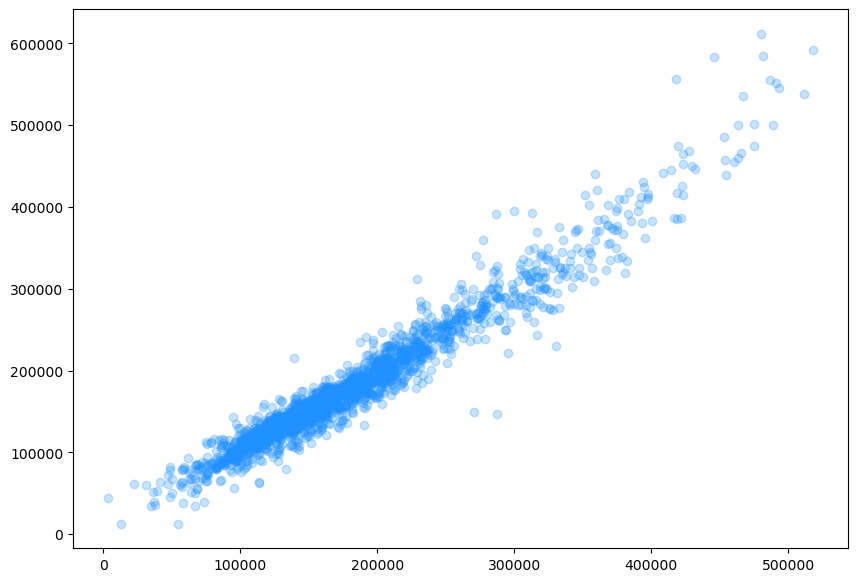

In [956]:
# Has equal variance of errors
plt.figure(figsize = (10, 7))
plt.scatter(y_pred, y, color = 'dodgerblue', alpha=.25);

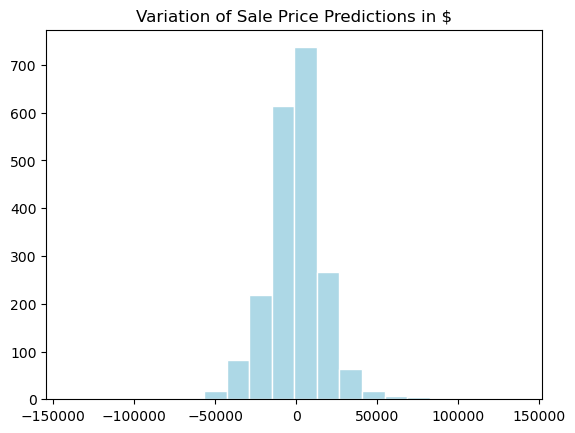

In [957]:
# Residuals are normally Distributed
# this is showing our model is doing well as there are not too many high values far away from the mean. Our margin of error is about $50k or less.
plt.hist(resids, bins=20, color='lightblue', edgecolor = 'white');
plt.title('Variation of Sale Price Predictions in $');

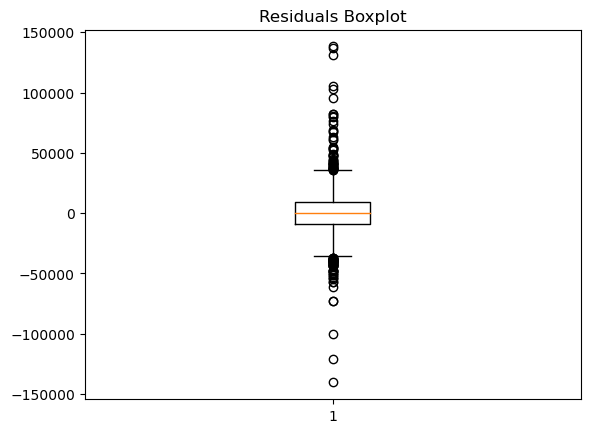

In [958]:
plt.boxplot(resids)
plt.title('Residuals Boxplot')
plt.show()

In [959]:
# Renamed columns for visualizations
renamed_columns = {
    'Misc Val': 'Misc Value',
    'Yr Sold': 'Year Sold',
    'Low Qual Fin SF': 'Finished Sq Ft',
    'Bsmt Half Bath': 'Basement Half Bathrooms',
    'MS SubClass': 'Bldg Class',
    'Kitchen AbvGr': 'Kitchens',
    'Gr Liv Area': 'Living Area',
    'Total Bsmt SF': 'Basement Sq Ft',
    '1st Flr SF': '1st Floor Sq Ft',
    'Year Remod/Add': 'Year Remodeled',
    'Garage Yr Blt': 'Garage Year',
    'Mas Vnr Area': 'Masonry Veneer Area',
    'TotRms AbvGrd': 'Rooms',
    'Open Porch SF': 'Open Porch Sq Ft',
    'Wood Deck SF': 'Wood Deck Sq Ft',
    'SalePrice': 'Sale Price',
    # Add more mappings as needed
}

# Rename multiple column headers
train_renamed_cols = train.rename(columns=renamed_columns)


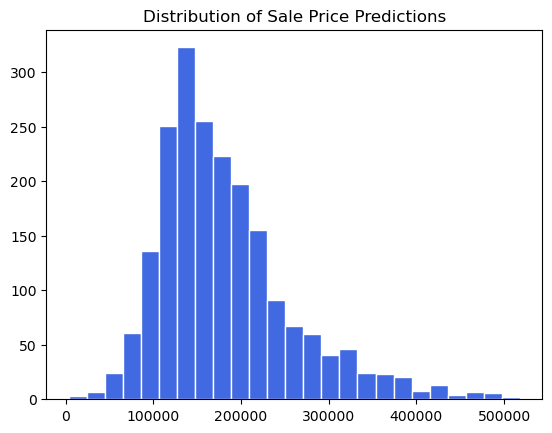

In [960]:
## Predictions are normally Distributed. Showing bulk of housing price predictions around $120k-$160k
plt.hist(y_pred, bins=25, color='royalblue', edgecolor = 'white');
plt.title('Distribution of Sale Price Predictions');

In [961]:
train['SalePrice'].mean()

181484.25244140625

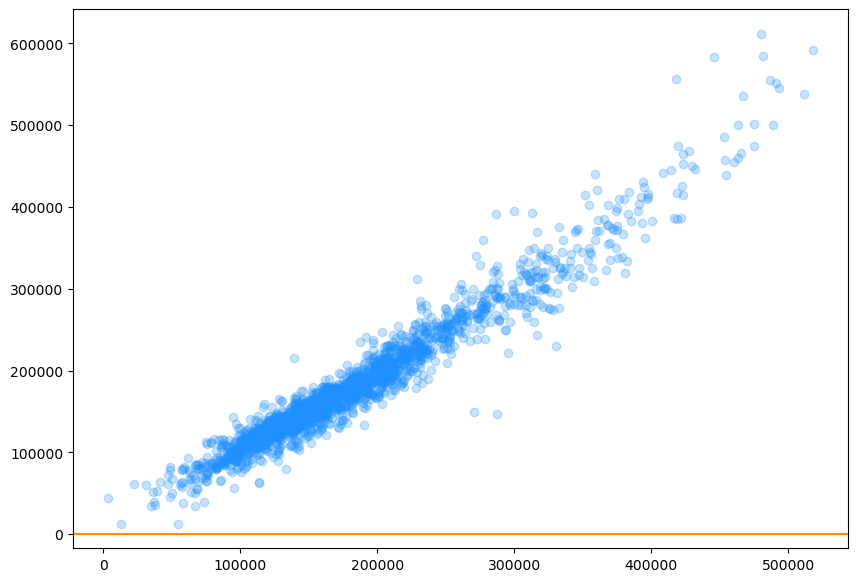

In [962]:
plt.figure(figsize = (10, 7))
plt.scatter(y_pred, y, color = 'dodgerblue', alpha=.25)
plt.axhline(0, color = 'darkorange');

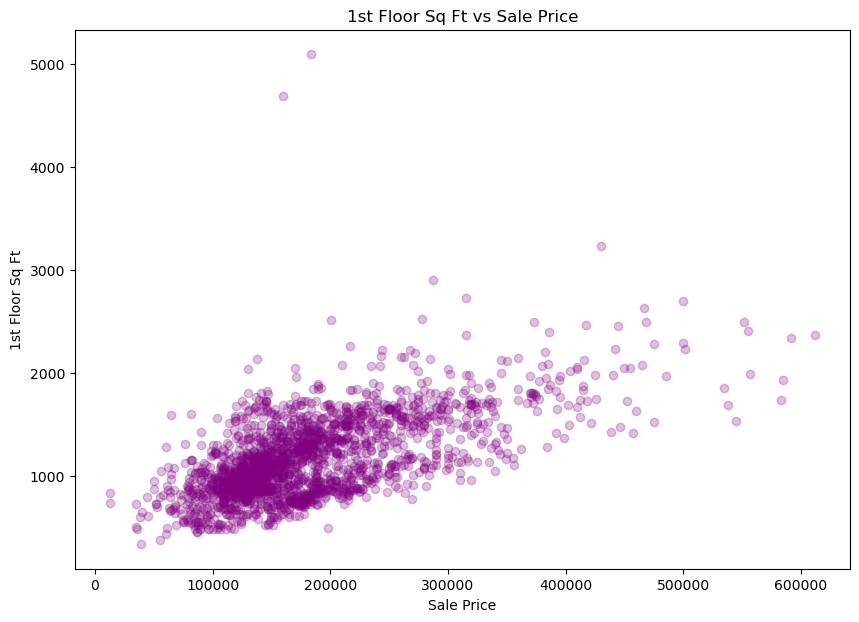

In [963]:
plt.figure(figsize = (10, 7))
plt.scatter(train_renamed_cols['Sale Price'], train_renamed_cols['1st Floor Sq Ft'], color = 'purple', alpha=.25)
plt.xlabel('Sale Price')
plt.ylabel('1st Floor Sq Ft')
plt.title('1st Floor Sq Ft vs Sale Price');

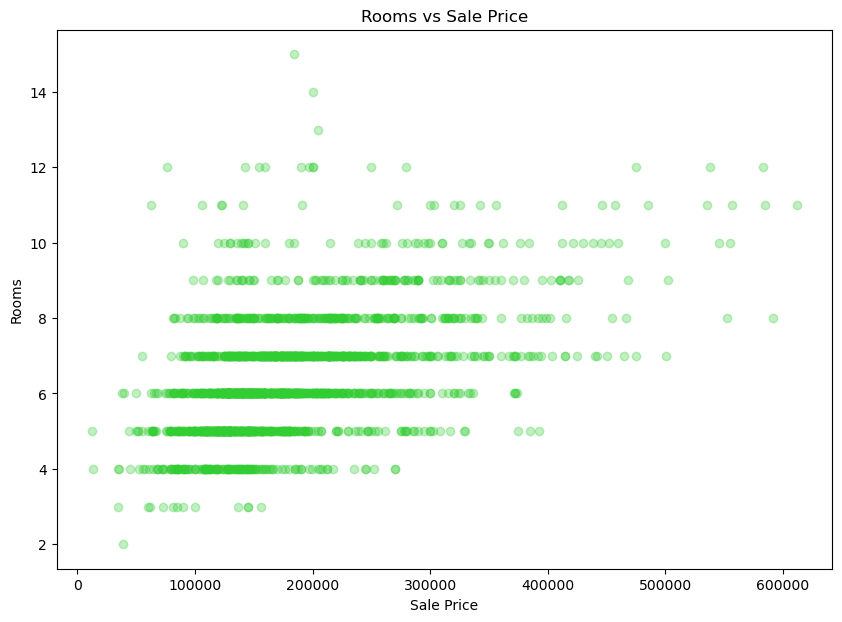

In [964]:
plt.figure(figsize = (10, 7))
plt.scatter(train_renamed_cols['Sale Price'], train_renamed_cols['Rooms'], color = 'limegreen', alpha=.3)
plt.xlabel('Sale Price')
plt.ylabel('Rooms')
plt.title('Rooms vs Sale Price');

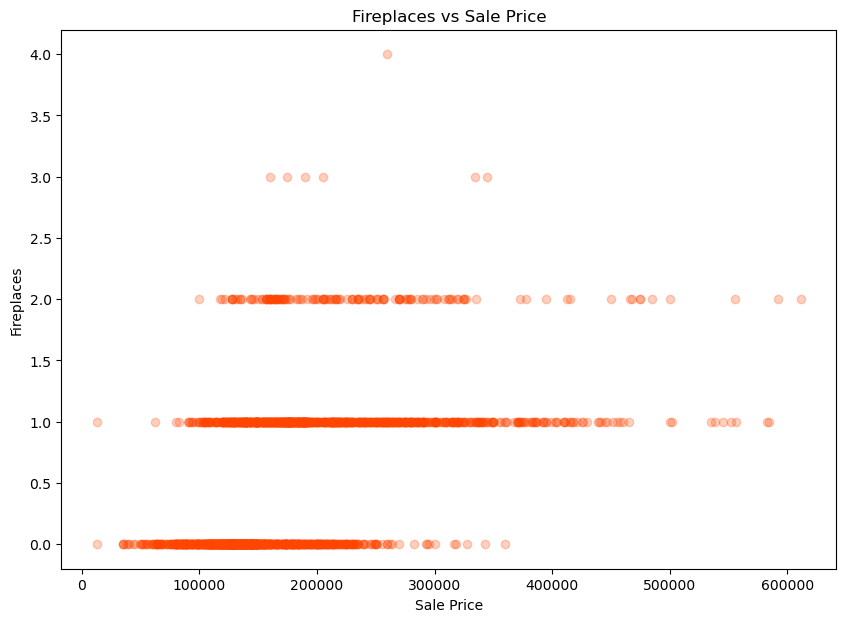

In [965]:
# Houses with just 1 fireplace had a much wider price range than houses with no fireplace
plt.figure(figsize = (10, 7))
plt.scatter(train_renamed_cols['Sale Price'], train_renamed_cols['Fireplaces'], color = 'orangered', alpha=.25)
plt.xlabel('Sale Price')
plt.ylabel('Fireplaces')
plt.title('Fireplaces vs Sale Price');